## Итоговое задание

Вам предложен набор с признаками съедобных и несъедобных грибов.  
Набор разбит на две части:  
- тренировочный griby_train.csv
- тестовый griby_test.csv

**Задача:**  
1. загрузить данные
2. провести разведочный анализ данных:
    * определить количество признаков
    * определить тип признаков
    * проверить на наличие пропущенных значений
    * визуализировать данные - распределение по категориям для съедобных и несъедобных грибов
    * построить графики с помощью какого-либо из методов снижения размерности, например, метода главных компонент
3. построить классификатор, который как можно более точно предсказывает съедобность грибов на основе предложенных признаков с помощью:  
    * логистической регрессии
    * метода опорных векторов (для SVM важно проводить подбор гиперпараметров)
    * решающего дерева (и визуализировать дерево)
    * градиентного бустинга
4. для метода опорных векторов провести подбор оптимальных параметров
5. оценить качество полученных моделей с использованием тестового набора (accuracy, ROC AUC), построить графики для визуализации качества предсказаний 
6. оценить важность признаков (необязательно)
    
Чтобы получить "хорошо", достаточно выполнить пункты 1 и 2, построить классификатор хотя бы с помощью одного метода и выполнить пункт 5.  
Чтобы получить "отлично", нужно выполнить все пункты заданий 1-5.  
Нужно быть готовым ответить на вопросы по вашему варианту решения.

Задание сдавать в виде jupyter-ноутбуков (\*.ipynb) или в виде скрипта в формате \*.py  
Оправить письмо с вариантом решения по адресу: antonec@ya.ru  
Обязательно указать ФИО!  

**ВАЖНО!!!**
- Код должен быть рабочим.  
- Помните про воспроизводимость &mdash; фиксируйте random-state везде, где необходимо.  
- Помните про переобучение! ***Обучаться на всем наборе данных, включая тестовый &mdash; плохая идея, качество ваших предсказаний я буду проверять на другом наборе данных! ***




***

#### Задание выполнил(а):  Мищенко Полина

***



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn import preprocessing, decomposition, manifold, model_selection, pipeline, cluster, datasets, mixture, metrics

from sklearn import linear_model as lm
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
#from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, roc_curve, precision_score, roc_auc_score, f1_score

from sklearn.svm import LinearSVC, SVC


%matplotlib inline 

C:\Users\pltfrmr\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<br>
![](./f4f4a14e77deb7c5bbde53ce7d6ce82b.gif)

### 1. Загрузка данных

In [4]:
## read test and train datasets:
data_train     = pd.read_csv('griby_train.txt',sep=',')
data_hold_out  = pd.read_csv('griby_test.txt',sep=',')

### 2. Разведочный анализ данных

In [5]:
## проверка на наличие пропущенных значений
data_train = data_train.replace('?', np.NaN)
data_hold_out = data_hold_out.replace('?', np.NaN)

In [6]:
print("Есть ли в data_train пропуски: {}".format(data_train.isnull().any().any()))

Есть ли в data_train пропуски: True


In [7]:
print("Есть ли в data_hold_out пропуски: {}".format(data_hold_out.isnull().any().any()))

Есть ли в data_hold_out пропуски: True


In [8]:
## сколько в датасете параметров? Признак class является целевым.
print("Количество параметров в датасете: {}".format(len(data_train.columns) - 1))

Количество параметров в датасете: 22


In [9]:
## для каждого признака вывести количество наблюдений для каждой категории
## например, с помощью метода value_counts
for i in data_train.columns.values:
    print("{}\n".format(data_train[i].value_counts()))

edible       1133
poisonous     971
Name: class, dtype: int64

convex     974
flat       807
knobbed    198
bell       116
sunken       7
conical      2
Name: cap_shape, dtype: int64

scaly      801
smooth     680
fibrous    623
Name: cap_surface, dtype: int64

brown       569
gray        508
red         350
yellow      298
white       258
buff         51
pink         45
cinnamon     15
purple        5
green         5
Name: cap_color, dtype: int64

no         1256
bruises     848
Name: bruises, dtype: int64

none        944
foul        536
spicy       141
fishy       140
anise       109
almond      109
pungent      61
creosote     49
musty        15
Name: odor, dtype: int64

free        2045
attached      59
Name: gill_attachment, dtype: int64

close      1699
crowded     405
Name: gill_spacing, dtype: int64

broad     1488
narrow     616
Name: gill_size, dtype: int64

buff         413
pink         388
white        314
brown        267
gray         204
chocolate    198
purple       121

C:\Users\pltfrmr\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


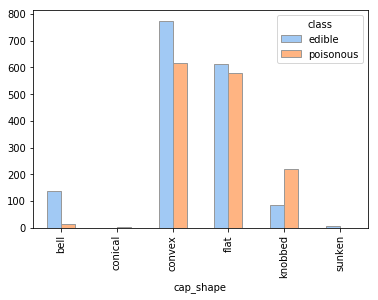

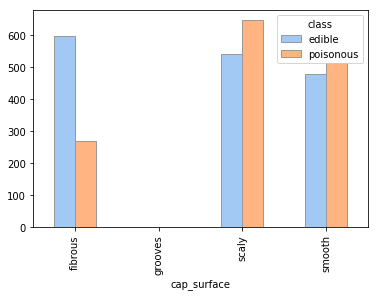

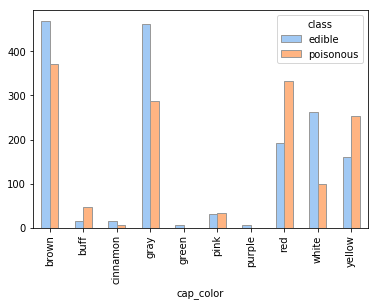

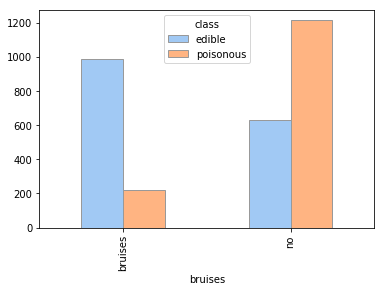

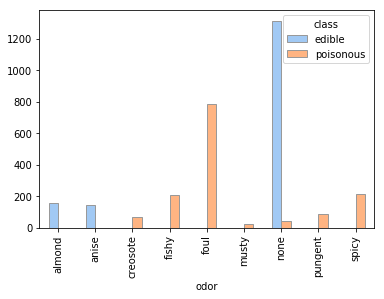

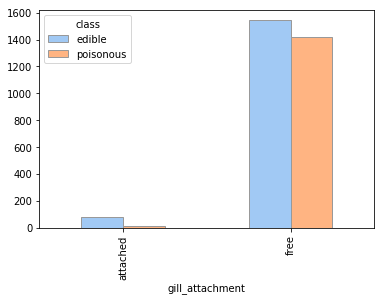

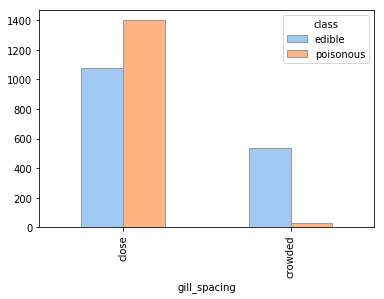

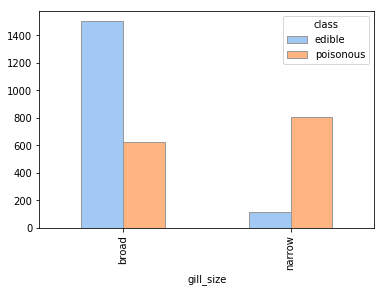

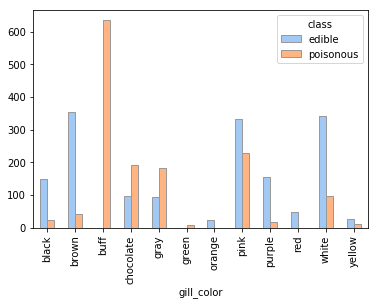

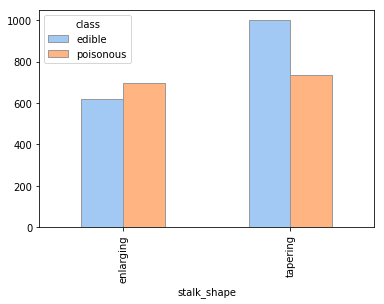

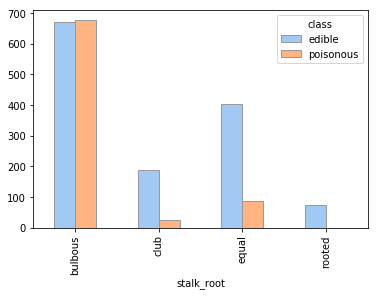

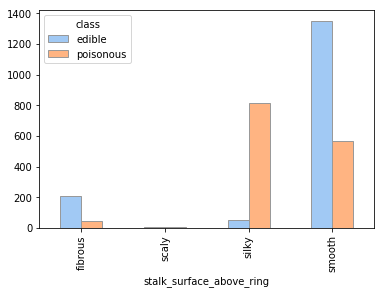

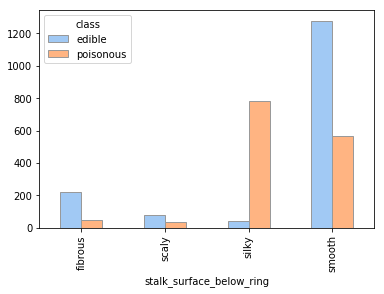

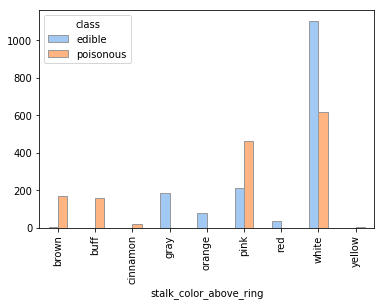

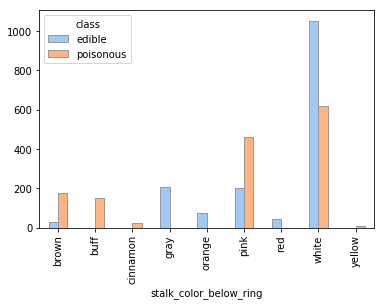

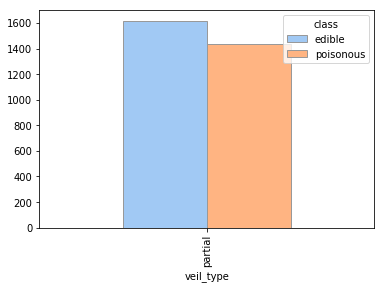

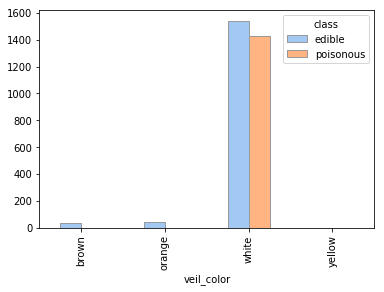

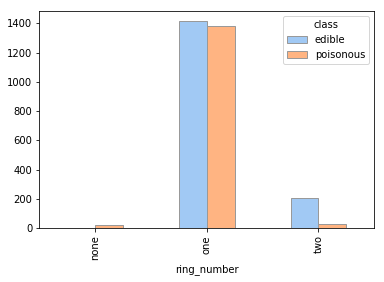

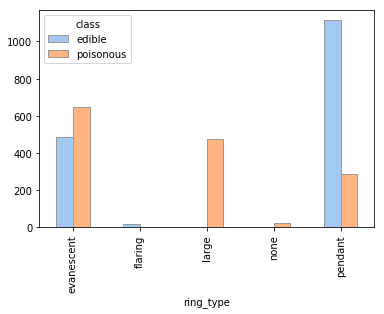

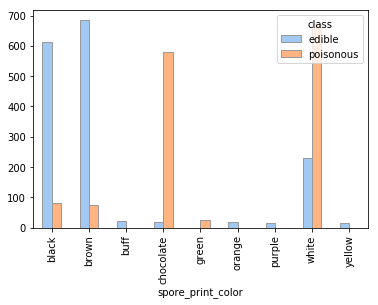

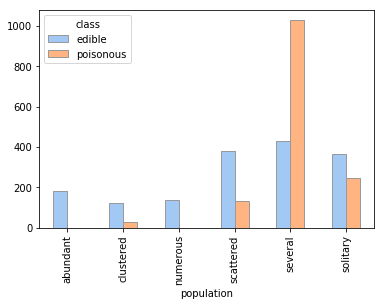

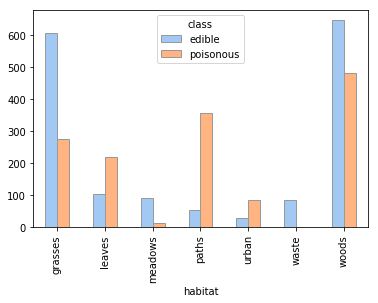

In [10]:
## для визуализации распределения наблюдений по категориям
## можно воспользоваться вот таким примером

data = data_train.copy()
data = data.append(data_hold_out)

for i in data.iloc[0:0,1:]:
    data[[i,'class']].groupby([i, 'class']).size().unstack().plot.bar(edgecolor=".6", #log= 'y',
                                                                                            color = sns.color_palette('pastel'));
## кстати, можно объединить data_train и data_test для построения графиков и анализа

In [12]:
## необходимо преобразовать признаки.
## используйте dummy-кодирование / one-hot-кодирование
## например, с помощью sklearn.preprocessing.OneHotEncoder или pandas.get_dummies
## NB! Необходимо убедиться, что в наборе train есть все варианты значений!
data_train_X    = pd.get_dummies(data_train.fillna(0).iloc[:, 1:])
data_hold_out_X = pd.get_dummies(data_hold_out.fillna(0).iloc[:, 1:] )
## вот так можно добиться соответствия порядка и количества столбцов в вашем тенировочном и тестовом наборах 
data_train_X, data_hold_out_X = data_train_X.align(data_hold_out_X, join='outer', axis=1, fill_value=0)

In [13]:
## проверьте размерность ваших данных!!! Если количество колонок не совпадает - нужно это исправить...
assert(data_train_X.shape[1] == data_hold_out_X.shape[1])

In [33]:
## импортируем следующие функции из scipy:
## pdist - для определения расстояний между объектами (возвращает в конденсированном виде)
## squareform - для превращения матрицы расстояний в квадратную (избыточную)
from scipy.spatial.distance import pdist, squareform

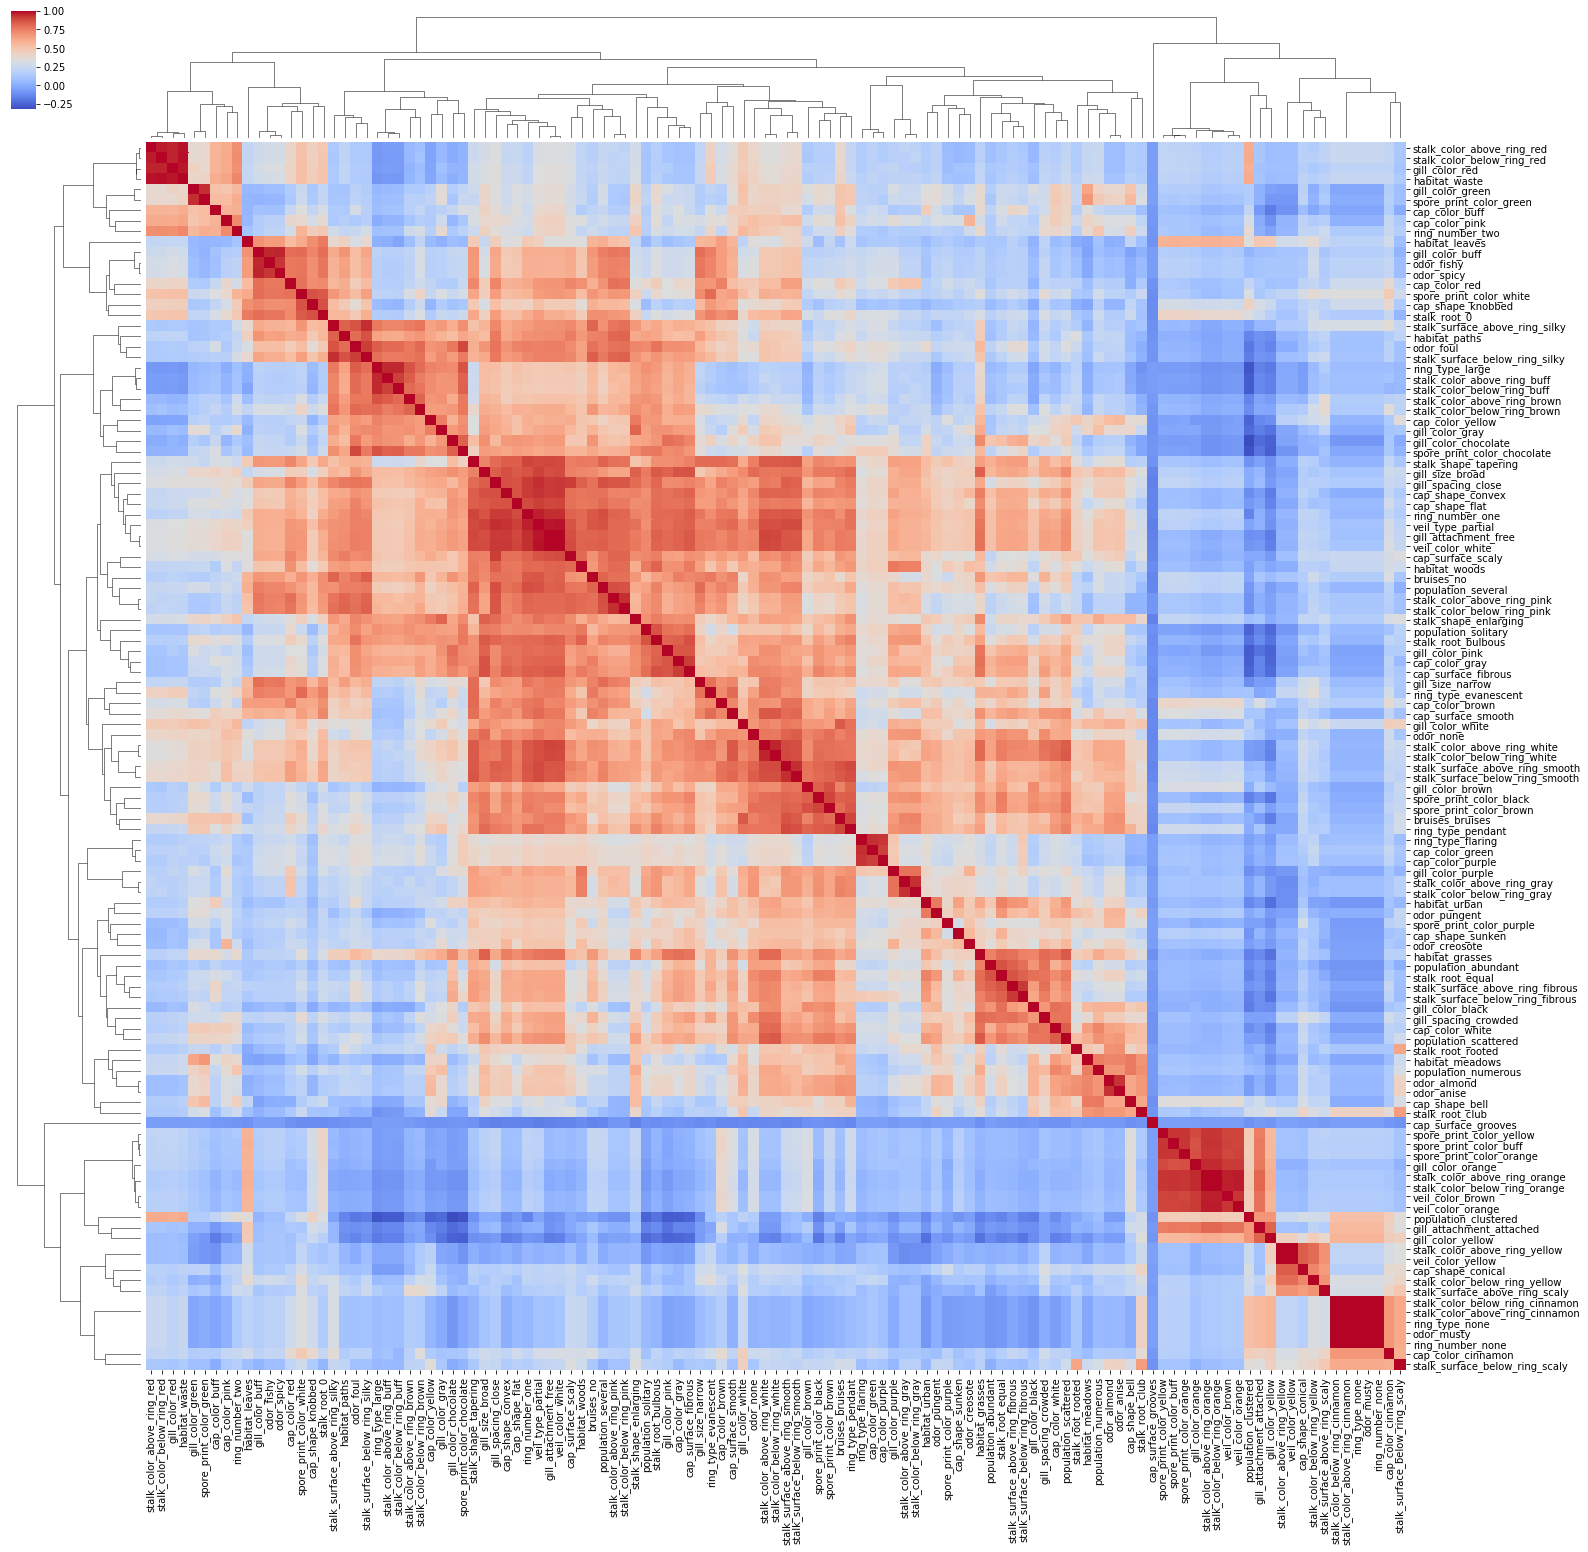

In [34]:
## Далее приведена информация из документации к scipy.spatial.distance
## можете попробовать посчитать матрицу сходства между признаками и визуализировать ее с помощью 
##  

## Computing distances over a large collection of vectors is inefficient for these functions. 
## Use pdist for this purpose.
## Distance functions between two numeric vectors u and v: 
##   braycurtis, canberra, chebyshev, cityblock, correlation, cosine, euclidean, jensenshannon, mahalanobis,
##   minkowski, seuclidean, sqeuclidean, wminkowski
## Distance functions between two boolean vectors (representing sets) u and v: 
##   dice, hamming, jaccard, kulsinski, rogerstanimoto, russellrao, sokalmichener, sokalsneath, yule

D = squareform(pdist(data_train_X.T.values, 'dice'))#'your_method')) ## матрица расстояний

## необходимо найти матрицу сходства
## создать на ее основе pandas.DataFrame, причем задать значения индекса и колонок, 
## соответствующие новым трансформированным признакам из таблицы shrooms_trainX
Sim = pd.DataFrame(D).corr(method='spearman')
Sim[np.isnan(Sim)] = 0.0
Sim.columns = list(data_train_X.columns)
Sim.index = list(data_train_X.columns)
## для функции seaborn.clustermap лучше дополнительно задать следующие параметры:
## cmap = 'coolwarm', figsize = (25, 25));
sns.clustermap(Sim, cmap = 'coolwarm', figsize = (25, 25));

In [44]:
## создадим numpy.array (или pandas.Series) с метками классов: 1 - edible, 0 - poisonous
y_train = np.array([1 if x == "edible" else 0 for x in data_train.iloc[:, 0]])
y_test  = np.array([1 if x == "edible" else 0 for x in data_hold_out.iloc[:, 0]])

Text(0.5,0,'z')

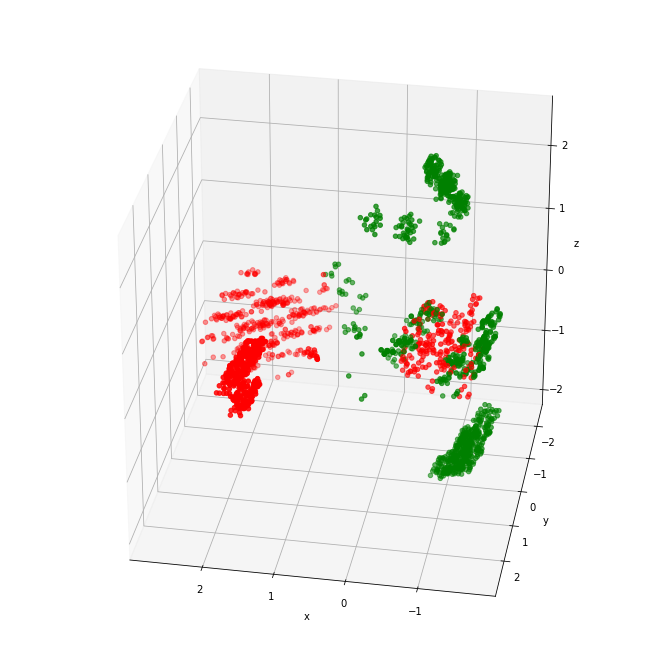

In [60]:
## проведем снижение размерности наших данных с помощью PCA, MDS или другого метода
## теперь можно построить диаграмму рассеяния для наших данных в трехмерном пространстве
pca = PCA(n_components=3, random_state=42)
scores = pca.fit_transform(data_train_X)
x, y, z = scores[:,0], scores[:,1], scores[:,2] # если scores -- numpy.array

#x, y, z = scores.iloc[:,0], scores.iloc[:,1], scores.iloc[:,2] # если scores -- pandas.DataFrame

class_cols = ['green' if x == 1 else 'red' for x in y_train] # -- цвета, соответствующие меткам классов

from mpl_toolkits.mplot3d import Axes3D ## для построения 3D-графиков
fig = plt.figure(figsize = (9, 9)) ## зададим размер фигуры
ax = Axes3D(fig)

ax.scatter(x, y, z, color=class_cols) 

ax.view_init(30, 100) ## изменяя эти параметры вы меняете угол зрения
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

### 3. Построение классификатора с помощью:
* логистической регрессии

In [15]:
## создадим пайплайн
## или построим модель без создания пайплайна
## используем кросс-валидацию

* метода опорных векторов (для SVM важно проводить подбор гиперпараметров)

In [16]:
## создадим пайплайн
## или построим модель без создания пайплайна
## используем кросс-валидацию
## лучше всего воспользоваться GridSearchCV или RandomizedSearchCV для подбора гиперпараметров

* решающего дерева (и визуализировать дерево — необязательно)

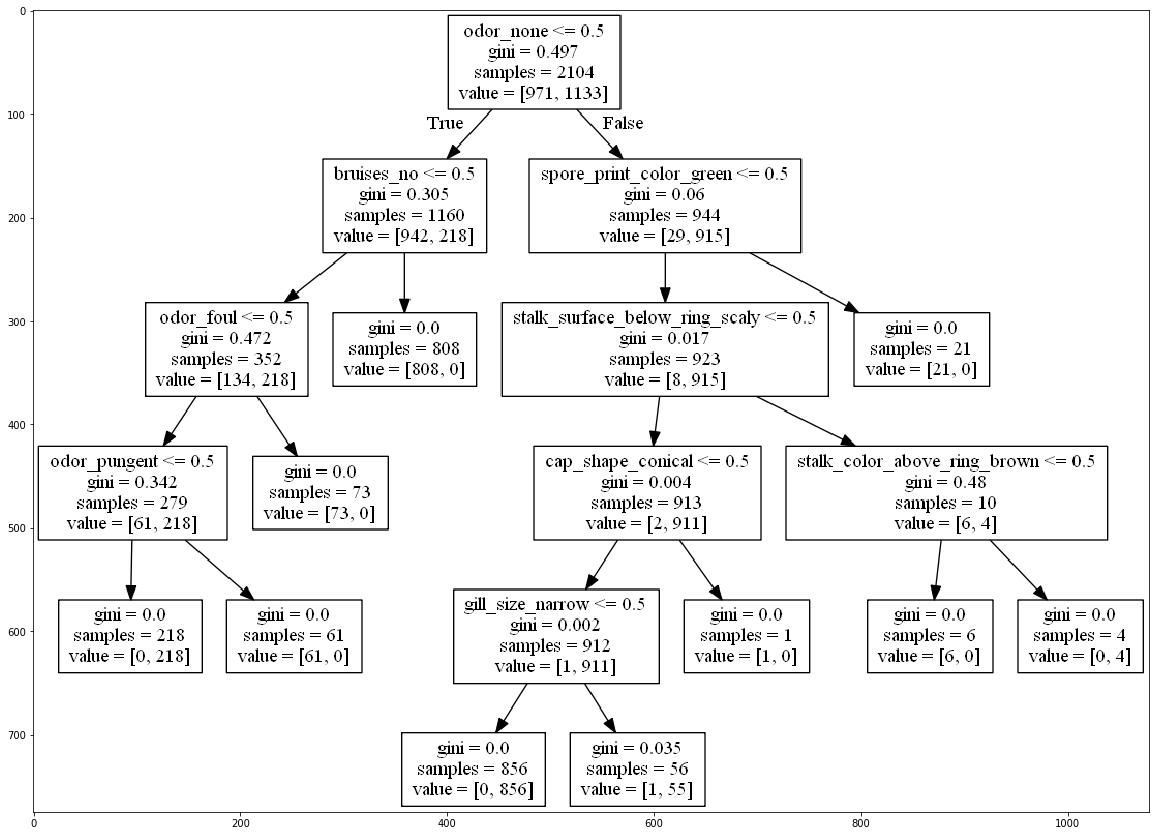

In [62]:
from os import system

clf_dt = DecisionTreeClassifier(max_depth=5, random_state=42)
clf_dt.fit(data_train_X, y_train)

dotfile = open("tree.dot", 'w')
export_graphviz(clf_dt, out_file = dotfile, feature_names = data_train_X.columns)
dotfile.close()
system("dot -Tpng tree.dot -o tree.png")

image = plt.imread('tree.png', 'r')
plt.figure(figsize=[20,20])
plt.imshow(image)

### 4. Оценка качества полученных моделей с использованием тестового набора 
* Accuracy, ROC AUC, построить графики для визуализации качества предсказаний

In [64]:
print(accuracy_score(y_test, clf_dt.predict(data_hold_out_X)))
print(roc_auc_score(y_test, clf_dt.predict(data_hold_out_X)))

0.9989440337909187
0.9989154013015185


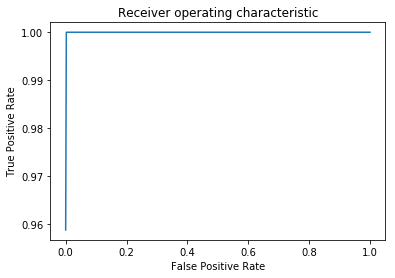

In [65]:
fpr, tpr, thresholds = roc_curve(y_test, clf_dt.predict_proba(data_hold_out_X)[:,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.plot(fpr,tpr)

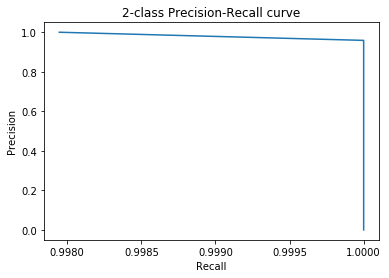

In [66]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, clf_dt.predict_proba(data_hold_out_X)[:,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve')
plt.plot(precision, recall)